# 2 Dimensional Histograms

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
import statsmodels.stats.multitest

import matplotlib.ticker as ticker

import cptac
import cptac.utils as u

# Step 1: Get Data Frame and Calculate Std Dev and Mean

Download data frame that has FDR corrected pvalues for all trans proteins. Next, calculate the total number of p values significant for each trans protein. Then calculate the mean and standard deviation of pvalues/ difference in medians across a trans gene. 

In [19]:
root = R'~\Github\WhenMutationsDontMatter\PTEN\Step_3_trans_effect\csv'
df_fdr_pvals = pd.read_csv(root+R"\all_pval_all_proteins.csv")
df_fdr_pvals = df_fdr_pvals.loc[df_fdr_pvals['Proteomics'] != 'PTEN'] # Drop PTEN

# Drop Kidney
cols = []
df_fdr_pvals = df_fdr_pvals.drop(cols)
df_fdr_pvals

,Proteomics,Gbm_P_Value,Gbm_Median,Hnscc_P_Value,Hnscc_Median,Luad_P_Value,Luad_Median,Lscc_P_Value,Lscc_Median,Brca_P_Value,Brca_Median,Ov_P_Value,Ov_Median,En_P_Value,En_Median,Colon_P_Value,Colon_Median
0,ARMH3,5.766739e-07,-0.405134,0.024047,-0.135941,0.222235,-0.37845,0.906857,-0.27970,NaN,NaN,NaN,NaN,0.034811,0.1503,NaN,NaN
1,CUTC,8.514758e-07,-0.553255,0.014672,-0.314307,0.056523,-1.01995,0.568489,-0.44585,0.349469,-0.48080,0.985704,-0.159424,0.330823,-0.2533,0.917530,-0.08210
2,CUL2,2.783477e-06,-0.586396,0.677585,0.017886,0.868772,0.05695,0.999848,0.04745,0.665878,0.17195,0.991659,0.033091,0.957970,0.0232,0.902073,-0.07690
3,PIP4K2A,2.783477e-06,-0.838882,0.038186,-0.224713,0.847730,0.04535,0.999848,0.24750,0.670623,-0.07435,0.985704,0.052955,0.502967,0.1690,0.883481,0.10135
4,GDI2,2.783477e-06,-0.610188,0.827100,0.001559,NaN,NaN,0.999848,-0.03735,0.789708,0.14995,0.985704,-0.067389,0.283190,0.1286,0.999502,-0.04450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15092,RETNLB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.17860
15093,SYCE3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.18575
15094,TFF2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.33000
15095,TRIM52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.30270


In [17]:

def Pvalue_sig(row):
    numSig = 0

    for item in row:
        if pd.isnull(item):
            continue
        if item < 0.05: # changed from .1????
            numSig += 1
            
    return numSig

In [25]:
#Only include genes that have data for at least 6/8 genes.
df_fdr_pvals = df_fdr_pvals.dropna(thresh=12, axis=0)

In [24]:
df_fdr_pvals["Num_sig"] = df_fdr_pvals.loc[:,["Gbm_P_Value","Hnscc_P_Value","Luad_P_Value","Lscc_P_Value",
                                              "Brca_P_Value","Ov_P_Value","En_P_Value","Colon_P_Value"]].apply(Pvalue_sig, axis = 1)
df_fdr_pvals = df_fdr_pvals.sort_values(by=['Num_sig'],ascending=False)
df_fdr_pvals

,Proteomics,Gbm_P_Value,Gbm_Median,Hnscc_P_Value,Hnscc_Median,Luad_P_Value,Luad_Median,Lscc_P_Value,Lscc_Median,Brca_P_Value,Brca_Median,Ov_P_Value,Ov_Median,En_P_Value,En_Median,Colon_P_Value,Colon_Median,Num_sig
1132,RIF1,0.021298,0.360544,0.038812,0.468772,0.999320,0.23970,0.999848,0.13570,0.723699,0.28535,0.985704,0.117336,0.001590,-0.54640,0.953484,-0.11350,3
276,SHOC2,0.003530,-0.264737,0.036457,-0.188018,0.003209,-0.60600,0.801388,-0.25585,0.330990,-0.42665,0.985704,-0.184659,0.086862,0.17920,0.800585,-0.07880,3
134,RAB8B,0.001609,-0.446976,0.023883,-0.376723,0.027098,-0.75010,0.999848,0.21995,0.923055,0.03295,0.991931,-0.010445,0.972666,0.34100,0.931817,0.00005,3
201,XPNPEP1,0.002241,-0.215091,0.507869,-0.092023,0.043887,-0.38075,0.999848,-0.19105,0.931088,-0.14370,0.985704,-0.150325,0.013970,0.47500,0.624087,-0.18910,3
1439,TPX2,0.031690,0.640139,0.039944,0.490643,0.778198,0.18745,0.999848,-0.10280,0.462570,-0.05995,0.985704,0.216007,0.021371,-0.80000,0.963829,-0.03050,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5127,SERPIND1,0.301334,-0.464742,0.316514,-0.307279,0.318870,-0.49895,0.999848,-0.05520,0.493399,-0.48955,0.985704,0.205481,0.435570,0.17900,0.987216,0.00900,0
5126,EMC2,0.301334,0.121113,0.348623,0.060871,0.461915,0.29065,0.999848,0.11970,0.767521,0.28710,0.985704,0.066198,0.923632,-0.00180,0.854580,-0.09460,0
5123,PC,0.301295,-0.301898,0.467900,0.001199,0.301530,1.43660,0.999848,-0.92235,0.897763,-0.00830,0.985704,0.218755,0.907455,0.06344,0.917530,-0.07250,0
5138,PA2G4,0.304425,0.121294,0.975381,0.024785,0.945427,-0.03865,0.999848,0.08585,NaN,NaN,0.985704,-0.017782,0.147138,-0.35350,0.896927,-0.02200,0


In [6]:
#Calculate mean and standard deviation for pvalues and Pearson Correlations
df_fdr_pvals["Standard_Deviation_P_value"] = df_fdr_pvals.loc[:,["P_value_Gbm","P_value_kidney","P_value_Ovar","P_value_Brca","P_value_Luad","P_value_hnscc","P_value_colon","P_value_Lscc"]].std(axis = 1)
df_fdr_pvals["Mean_P_value"] = df_fdr_pvals.loc[:,["P_value_Gbm","P_value_kidney","P_value_Ovar","P_value_Brca","P_value_Luad","P_value_hnscc","P_value_colon","P_value_Lscc"]].mean(axis = 1)
df_fdr_pvals["Standard_Deviation_Correlation"] = (df_fdr_pvals.loc[:,["Correlation_Gbm","Correlation_kidney","Correlation_Ovar","Correlation_Brca","Correlation_Luad","Correlation_hnscc","Correlation_colon","Correlation_Lscc"]].std(axis = 1))
df_fdr_pvals["Mean_Correlation"] = (df_fdr_pvals.loc[:,["Correlation_Gbm","Correlation_kidney","Correlation_Ovar","Correlation_Brca","Correlation_Luad","Correlation_hnscc","Correlation_colon","Correlation_Lscc"]].mean(axis = 1))



In [7]:
#Keep trans genes that are significant in atleast 1 gene. 

df_fdr_pvals_1 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([1,2,3,4,5,6,7,8])]
df_fdr_pvals_1

,Correlation_Gbm,P_value_Gbm,Correlation_kidney,P_value_kidney,Correlation_Ovar,P_value_Ovar,Correlation_Brca,P_value_Brca,Correlation_Luad,P_value_Luad,...,P_value_hnscc,Correlation_colon,P_value_colon,Correlation_Lscc,P_value_Lscc,Num_sig,Standard_Deviation_P_value,Mean_P_value,Standard_Deviation_Correlation,Mean_Correlation
Comparison,,,,,,,,,,,,,,,,,,,,,
MYO10_proteomics,0.447478,2.894593e-04,-0.263921,0.049045,0.374118,0.035041,0.515801,5.191477e-07,0.230896,0.089498,...,2.728434e-03,NaN,NaN,0.292466,4.901629e-02,7,0.033619,0.032231,0.257917,0.281063
PHLDA1_proteomics,0.816848,3.507071e-21,0.254436,0.060261,NaN,NaN,0.364797,2.164413e-03,0.260110,0.074530,...,8.888640e-12,0.386104,0.122847,0.713420,2.644826e-14,6,0.049396,0.037115,0.231588,0.494284
CNNM4_proteomics,-0.372324,3.167867e-03,0.069926,0.718877,0.076606,0.751602,-0.260055,2.329196e-02,0.270616,0.041016,...,3.293176e-02,0.352937,0.013936,0.311652,3.142153e-02,6,0.329428,0.202031,0.273997,0.091721
LNPK_proteomics,0.252970,6.764180e-02,0.409399,0.000817,0.317765,0.078673,0.203691,8.646543e-02,0.305844,0.018953,...,3.069001e-01,0.123650,0.457606,0.279492,6.423666e-02,6,0.160432,0.135162,0.092969,0.256190
WIPF1_proteomics,-0.423818,6.449551e-04,-0.402723,0.000991,-0.108786,0.637397,0.232304,4.629351e-02,-0.287583,0.028363,...,2.959587e-04,0.270649,0.067143,-0.145960,4.329471e-01,6,0.244051,0.151759,0.283247,-0.162398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CXorf56_proteomics,0.130223,4.137366e-01,0.093333,0.591041,-0.049155,0.848914,0.051987,7.159177e-01,0.312022,0.016377,...,7.144387e-01,-0.048365,0.808190,-0.113030,5.805571e-01,1,0.268878,0.586146,0.132629,0.055648
BBS2_proteomics,0.000036,9.998937e-01,0.277386,0.037316,0.236561,0.238429,-0.139017,2.673604e-01,0.101418,0.527038,...,9.137802e-01,NaN,NaN,-0.110578,5.925849e-01,1,0.357350,0.510915,0.159828,0.056524
F12_proteomics,-0.129646,4.156574e-01,-0.033960,0.872092,0.275948,0.134771,0.176276,1.454733e-01,-0.383035,0.002152,...,8.966851e-01,0.130331,0.432160,-0.018513,9.497880e-01,1,0.380585,0.481097,0.203463,0.005749


# Step 2: Plot 2D Histogram

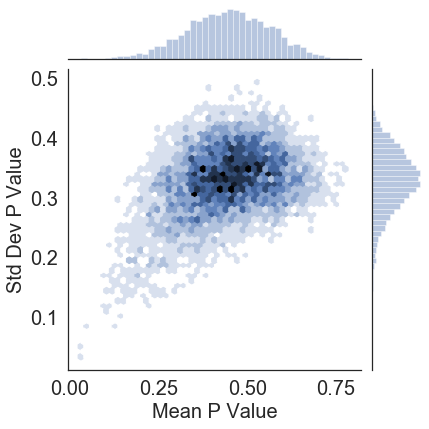

In [8]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_1, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("EGFR_Fig_1C_Pvalue_sig_atleast1_cancer.png", dpi = 300)

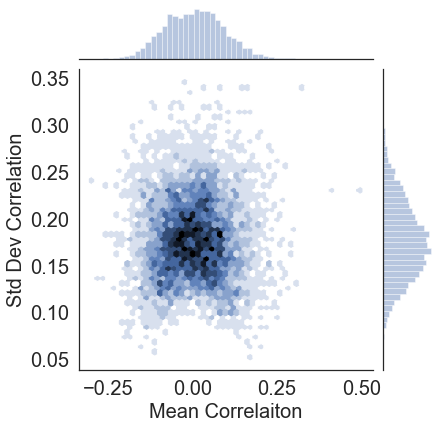

In [9]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_1, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("EGFR_Fig_1C_Corr_atleast1_cancer.png", dpi = 300)
plt.show()

# Filter for genes significant in at least 2 Cancers 

In [10]:

df_fdr_pvals_2 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([2,3,4,5,6,7,8])]

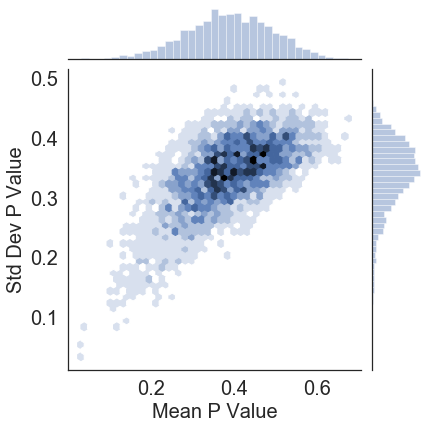

In [11]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_2, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("EGFR_Fig_1C_Pvalue_atleast2_cancers.png", dpi = 300)

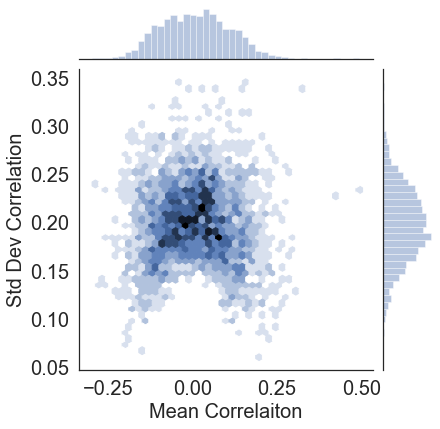

In [12]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_2, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("EGFR_Fig_1C_Corr_atleast2_cancers.png", dpi = 300)
plt.show()

# At least 3 Cancers

In [13]:

df_fdr_pvals_3 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([3,4,5,6,7,8])]

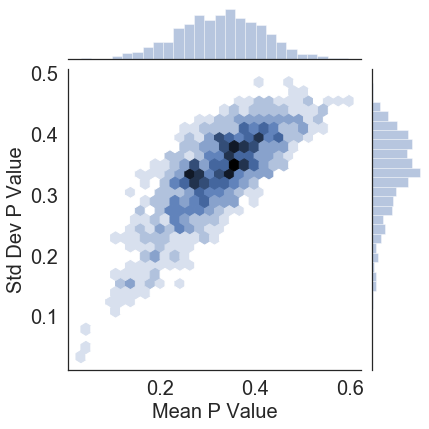

In [14]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_3, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("EGFR_Fig_1C_Pvalue_EGFR_atleast3_cancers.png", dpi = 300)

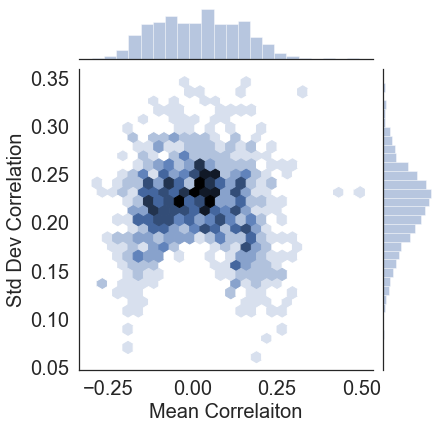

In [15]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_3, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("EGFR_Fig_1C_Corr_EGFR_atleast3_cancers.png", dpi = 300)
plt.show()

# Atleast 4

In [16]:

df_fdr_pvals_4 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([4,5,6,7,8])]

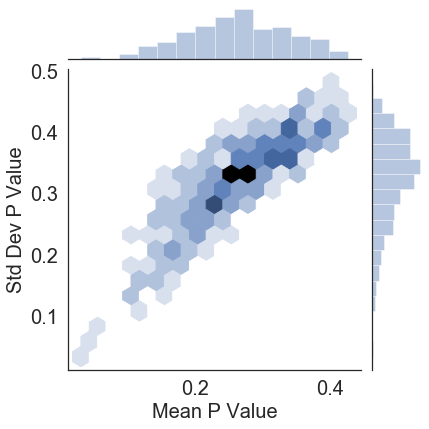

In [17]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_4, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("EGFR_Fig_1C_Pvalue_EGFR_atleast4_cancers.png", dpi = 300)

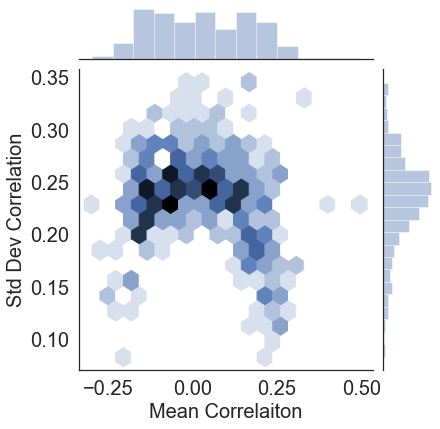

In [18]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_4, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("EGFR_Fig_1C_Corr_atleast4_cancers.png", dpi = 300)
plt.show()

In [19]:
df_fdr_pvals_1

,Correlation_Gbm,P_value_Gbm,Correlation_kidney,P_value_kidney,Correlation_Ovar,P_value_Ovar,Correlation_Brca,P_value_Brca,Correlation_Luad,P_value_Luad,...,P_value_hnscc,Correlation_colon,P_value_colon,Correlation_Lscc,P_value_Lscc,Num_sig,Standard_Deviation_P_value,Mean_P_value,Standard_Deviation_Correlation,Mean_Correlation
Comparison,,,,,,,,,,,,,,,,,,,,,
MYO10_proteomics,0.447478,2.894593e-04,-0.263921,0.049045,0.374118,0.035041,0.515801,5.191477e-07,0.230896,0.089498,...,2.728434e-03,NaN,NaN,0.292466,4.901629e-02,7,0.033619,0.032231,0.257917,0.281063
PHLDA1_proteomics,0.816848,3.507071e-21,0.254436,0.060261,NaN,NaN,0.364797,2.164413e-03,0.260110,0.074530,...,8.888640e-12,0.386104,0.122847,0.713420,2.644826e-14,6,0.049396,0.037115,0.231588,0.494284
CNNM4_proteomics,-0.372324,3.167867e-03,0.069926,0.718877,0.076606,0.751602,-0.260055,2.329196e-02,0.270616,0.041016,...,3.293176e-02,0.352937,0.013936,0.311652,3.142153e-02,6,0.329428,0.202031,0.273997,0.091721
LNPK_proteomics,0.252970,6.764180e-02,0.409399,0.000817,0.317765,0.078673,0.203691,8.646543e-02,0.305844,0.018953,...,3.069001e-01,0.123650,0.457606,0.279492,6.423666e-02,6,0.160432,0.135162,0.092969,0.256190
WIPF1_proteomics,-0.423818,6.449551e-04,-0.402723,0.000991,-0.108786,0.637397,0.232304,4.629351e-02,-0.287583,0.028363,...,2.959587e-04,0.270649,0.067143,-0.145960,4.329471e-01,6,0.244051,0.151759,0.283247,-0.162398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CXorf56_proteomics,0.130223,4.137366e-01,0.093333,0.591041,-0.049155,0.848914,0.051987,7.159177e-01,0.312022,0.016377,...,7.144387e-01,-0.048365,0.808190,-0.113030,5.805571e-01,1,0.268878,0.586146,0.132629,0.055648
BBS2_proteomics,0.000036,9.998937e-01,0.277386,0.037316,0.236561,0.238429,-0.139017,2.673604e-01,0.101418,0.527038,...,9.137802e-01,NaN,NaN,-0.110578,5.925849e-01,1,0.357350,0.510915,0.159828,0.056524
F12_proteomics,-0.129646,4.156574e-01,-0.033960,0.872092,0.275948,0.134771,0.176276,1.454733e-01,-0.383035,0.002152,...,8.966851e-01,0.130331,0.432160,-0.018513,9.497880e-01,1,0.380585,0.481097,0.203463,0.005749


In [20]:
prot_genes_list = df_fdr_pvals_1.index.to_list()

In [21]:
def anydup(thelist):
    seen = set()
    for x in thelist:
        if x in seen: return True
        seen.add(x)
    return False

In [22]:
anydup(prot_genes_list)

False

In [23]:
df_fdr_pvals_1['Num_sig'].value_counts()

1    3122
2    2043
3     886
4     307
5      91
6      17
7       1
Name: Num_sig, dtype: int64